
# Lab 4 Sample Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

class GenData:
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, (x > y).astype(np.int64).reshape((-1, 1))

    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    def _gen_chessboard(n=100):
        """Data generation (Chessboard)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64).reshape(
            (-1, 1)
        )

    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR" or mode == "Chessboard"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor, "Chessboard": GenData._gen_chessboard}[mode]

        return data_gen_func(n)

class Kaiming:
    def process(*args, **kwds):
        raise NotImplementedError
    
class SigmoidKaiming(Kaiming):
    @staticmethod
    def process(x):
        return x * np.sqrt(1. / x.shape[1])
    
class ReLUKaiming(Kaiming):
    @staticmethod
    def process(x):
        return x * np.sqrt(2. / x.shape[1])
    
class SiLUKaiming(Kaiming):
    @staticmethod
    def process(x):
        return x * np.sqrt(1. / x.shape[1])
    
class LeakyReLUKaiming(Kaiming):
    @staticmethod
    def process(x):
        return x * np.sqrt(2. / x.shape[1])

class Linear:
    def __init__(self, input_size, output_size, kaiming: Kaiming=None, momentum=0):
        """A hand-crafted implementation of perceptron.

        Args:
            input_size:              the size of input data.
            output_size:             the size of output data.
            is_kaiming (optional):   whether to use kaiming initialization.
            momentum (optional):     the momentum of optimizer.
            weight_decay (optional): the weight decay of optimizer.
        """
        self.weights = np.random.randn(input_size, output_size) 
        if kaiming:
            self.weights = kaiming.process(self.weights)
        self.biases = np.zeros(output_size)
        self.weight_momentum = np.zeros_like(self.weights)
        self.bias_momentum = np.zeros_like(self.biases)
        self.input = None
        self.momentum = momentum

    def __call__(self, inputs):
        """Forward pass of perceptron.

        Args:
            inputs (np.ndarray):    the input data to the perceptron.

        Returns:
            np.ndarray: the output of perceptron.
        """
        self.input = inputs
        # print(f"dot: {np.dot(inputs, self.weights) + self.biases}")
        return np.dot(inputs, self.weights) + self.biases
    
    # @njit
    def update(self, error, learning_rate):
        """Update the weights of perceptron.

        Args:
            inputs (np.ndarray):    the input data to the perceptron.
            error (np.ndarray):     the error of perceptron.
            learning_rate (float):  the learning rate of training.
        """    
        batch_size = self.input.shape[0]
        weight_gradient = np.dot(self.input.T, error) / batch_size
        bias_gradient = np.sum(error, axis=0) / batch_size
        grad_inputs = np.dot(error, self.weights.T)

        self.weight_momentum = self.momentum * self.weight_momentum + learning_rate * weight_gradient
        self.bias_momentum = self.momentum * self.bias_momentum + learning_rate * bias_gradient

        self.weights -= self.weight_momentum
        self.biases -= self.bias_momentum

        return grad_inputs

class Activation:
    @staticmethod
    def process(*args, **kwds):
        raise NotImplementedError
    
    @staticmethod
    def derivative(*args, **kwds):
        raise NotImplementedError
    
class Sigmoid(Activation):
    @staticmethod
    def process(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def derivative(y):
        return y * (1 - y)
    
class ReLU(Activation):
    @staticmethod
    def process(x):
        return np.maximum(0, x)
    
    @staticmethod
    def derivative(y):
        return (y > 0).astype(np.float64)
    
class LeakyReLU(Activation):
    @staticmethod
    def process(x):
        return np.maximum(0.1 * x, x)
    
    @staticmethod
    def derivative(y):
        return (y > 0).astype(np.float64) + 0.1 * (y <= 0).astype(np.float64)
    
class SiLU(Activation):
    @staticmethod
    def process(x):
        x = np.clip(x, -500, 500)
        return x / (1 + np.exp(-x))
    
    @staticmethod
    def derivative(y):
        return y + (1 - y) / (1 + np.exp(-y))

class SimpleNet:
    def __init__(self, num_step=6000, print_interval=100, learning_rate=1e-2, momentum=None, is_kaiming=False, activate_function: Activation=Sigmoid):  # don't change print_interval
        """A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.num_step = num_step
        self.print_interval = print_interval
        self.learning_rate = learning_rate
        self.ac_fn = activate_function

        kaiming = None
        if is_kaiming:
            kaiming = {"Sigmoid": SigmoidKaiming, "ReLU": ReLUKaiming, "SiLU": SiLUKaiming, "LeakyReLU": LeakyReLUKaiming}[activate_function.__name__]
        # Model parameters initialization
        # hidden layer 1: 100 nodes
        # hidden layer 2: 50 nodes
        # hidden layer 3: 10 nodes
        # Please initiate your network parameters here.

        input_size = 2
        hidden1_size = 100
        hidden2_size = 50
        hidden3_size = 10
        output_size = 1

        self.layer1 = Linear(input_size, hidden1_size, kaiming=kaiming, momentum=momentum)
        self.layer2 = Linear(hidden1_size, hidden2_size, kaiming=kaiming, momentum=momentum)
        self.layer3 = Linear(hidden2_size, hidden3_size, kaiming=kaiming, momentum=momentum)
        self.layer4 = Linear(hidden3_size, output_size, kaiming=kaiming, momentum=momentum)

    def plot_result(data, gt_y, pred_y):
        """Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[0] == gt_y.shape[0] == pred_y.shape[0], f"{data.shape}, {gt_y.shape}, {pred_y.shape}"

        plt.figure(figsize=(11, 5))

        cmap = plt.cm.bwr

        plt.subplot(121)
        plt.title("Ground Truth", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=gt_y[:,0], cmap=cmap, vmin=0.0, vmax=1.0)

        plt.subplot(122)
        plt.title("Prediction", fontsize=18)
        plt.scatter(data[:, 0], data[:, 1], c=pred_y[:, 0], cmap=cmap, vmin=0.0, vmax=1.0)

        plt.show()

    def forward(self, x):
        """Implementation of the forward pass.
        It should accepts the inputs and passing them through the network and return results.
        """
        """ FILL IN HERE """
        # print(f"input: {x}")
        x = self.ac_fn.process(self.layer1(x))
        # print(f"layer1: {x}")
        x = self.ac_fn.process(self.layer2(x))
        # print(f"layer2: {x}")
        x = self.ac_fn.process(self.layer3(x))
        # print(f"layer3: {x}")
        self.output = Sigmoid.process(self.layer4(x))
        # print(f"output: {self.output}")

        return self.output

    def backward(self):
        """Implementation of the backward pass.
        It should utilize the saved loss to compute gradients and update the network all the way to the front.
        """
        """ FILL IN HERE """
        _error = self.error * Sigmoid.derivative(self.output)
        _error = self.layer4.update(_error, self.learning_rate)

        _error *= self.ac_fn.derivative(self.layer4.input)
        _error = self.layer3.update(_error, self.learning_rate)

        _error *= self.ac_fn.derivative(self.layer3.input)
        _error = self.layer2.update(_error, self.learning_rate)
        
        _error *= self.ac_fn.derivative(self.layer2.input)
        _error = self.layer1.update(_error, self.learning_rate)

    def train(self, inputs, labels):
        """The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]

        for epochs in range(self.num_step):
            loss = 0.0
            for idx in range(n):
                # operation in each training step:
                #   1. forward passing
                #   2. compute loss
                #   3. propagate gradient backward to the front
                self.output = self.forward(inputs[idx : idx + 1, :])
                self.error = self.output - labels[idx : idx + 1, :]
                self.backward()

                loss += np.sum(self.error)        

            if epochs % self.print_interval == 0:
                print("Epochs {} ".format(epochs), end="")
                self.test(inputs, labels)

        print("Training finished")
        self.test(inputs, labels)

    def test(self, inputs, labels):
        """The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = self.forward(inputs[idx : idx + 1, :])
            error += abs(result - labels[idx : idx + 1, :])

        error /= n

        """ Print or plot your results in your preferred forms"""
        print("accuracy: %.2f" % ((1 - error) * 100) + "%")
        return ((1 - error) * 100)

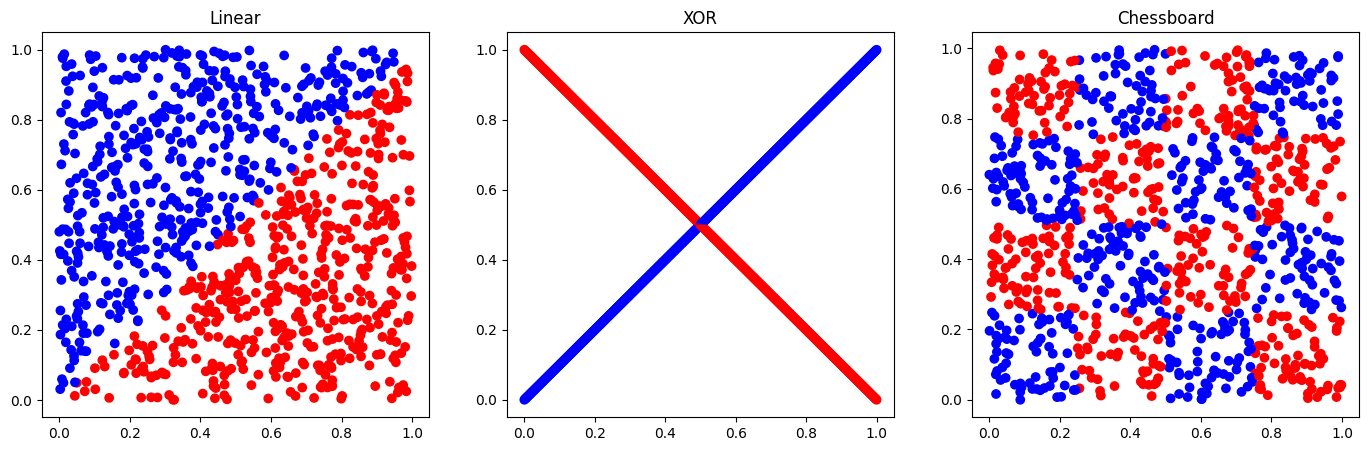

In [2]:
plt.figure(figsize=(17, 5))
for i, name in enumerate(['Linear', 'XOR', 'Chessboard']):
    data, label = GenData.fetch_data(name, 1000)
    plt.subplot(1,3,i+1)
    plt.scatter(data[:, 0], data[:, 1], c=label[:, 0], cmap=plt.cm.bwr)
    plt.title(name)

### Run "Linear"

Epochs 0 accuracy: 50.05%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 97.66%
Epochs 200 accuracy: 98.64%
Epochs 300 accuracy: 99.16%
Epochs 400 accuracy: 98.95%
Epochs 500 accuracy: 98.52%
Epochs 600 accuracy: 98.80%
Epochs 700 accuracy: 98.99%
Epochs 800 accuracy: 99.36%
Epochs 900 accuracy: 99.40%
Epochs 1000 accuracy: 99.42%
Epochs 1100 accuracy: 99.42%
Epochs 1200 accuracy: 99.40%
Epochs 1300 accuracy: 99.55%
Epochs 1400 accuracy: 98.86%
Epochs 1500 accuracy: 99.58%
Epochs 1600 accuracy: 99.28%
Epochs 1700 accuracy: 99.18%
Epochs 1800 accuracy: 99.63%
Epochs 1900 accuracy: 99.64%
Training finished
accuracy: 99.63%


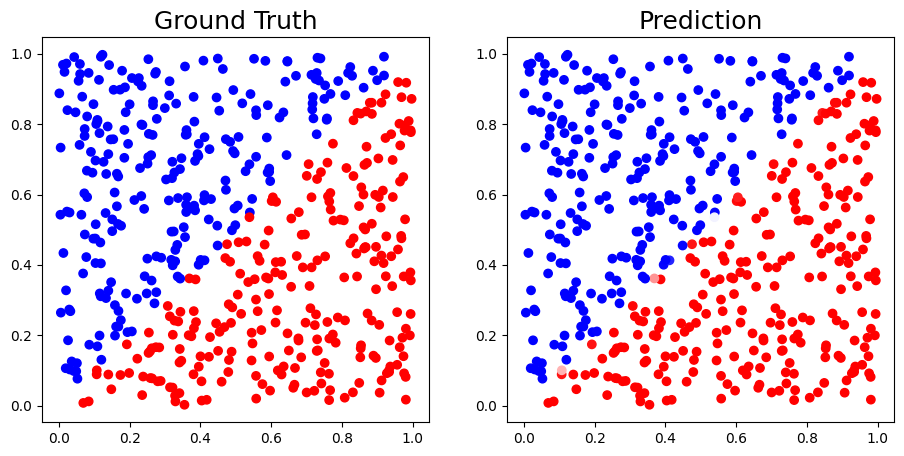

In [3]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Linear", 500)

net = SimpleNet(2000, momentum=0.95, is_kaiming=True)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 89.97%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 97.79%
Epochs 200 accuracy: 99.14%
Epochs 300 accuracy: 99.04%
Epochs 400 accuracy: 99.20%
Epochs 500 accuracy: 99.43%
Epochs 600 accuracy: 99.74%
Epochs 700 accuracy: 99.22%
Epochs 800 accuracy: 99.42%
Epochs 900 accuracy: 99.95%
Epochs 1000 accuracy: 99.97%
Epochs 1100 accuracy: 99.98%
Epochs 1200 accuracy: 99.98%
Epochs 1300 accuracy: 99.99%
Epochs 1400 accuracy: 99.99%
Epochs 1500 accuracy: 99.99%
Epochs 1600 accuracy: 99.99%
Epochs 1700 accuracy: 99.99%
Epochs 1800 accuracy: 99.99%
Epochs 1900 accuracy: 99.99%
Training finished
accuracy: 99.99%


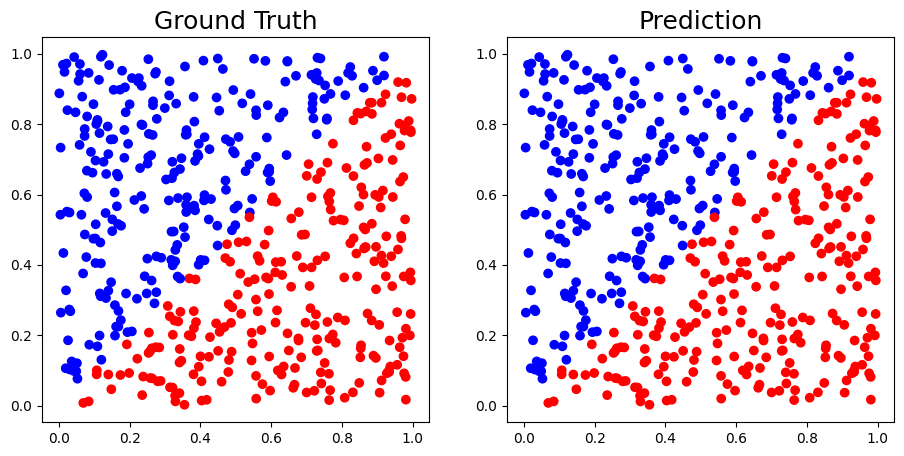

In [4]:
""" Customize your own code if needed """
net = SimpleNet(2000, momentum=0.95, is_kaiming=True, activate_function=ReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 85.67%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 98.61%
Epochs 200 accuracy: 99.08%
Epochs 300 accuracy: 99.07%
Epochs 400 accuracy: 98.45%
Epochs 500 accuracy: 98.90%
Epochs 600 accuracy: 99.63%
Epochs 700 accuracy: 98.92%
Epochs 800 accuracy: 99.64%
Epochs 900 accuracy: 99.55%
Epochs 1000 accuracy: 99.45%
Epochs 1100 accuracy: 99.78%
Epochs 1200 accuracy: 99.95%
Epochs 1300 accuracy: 99.97%
Epochs 1400 accuracy: 99.98%
Epochs 1500 accuracy: 99.99%
Epochs 1600 accuracy: 99.99%
Epochs 1700 accuracy: 99.99%
Epochs 1800 accuracy: 99.99%
Epochs 1900 accuracy: 99.99%
Training finished
accuracy: 99.99%


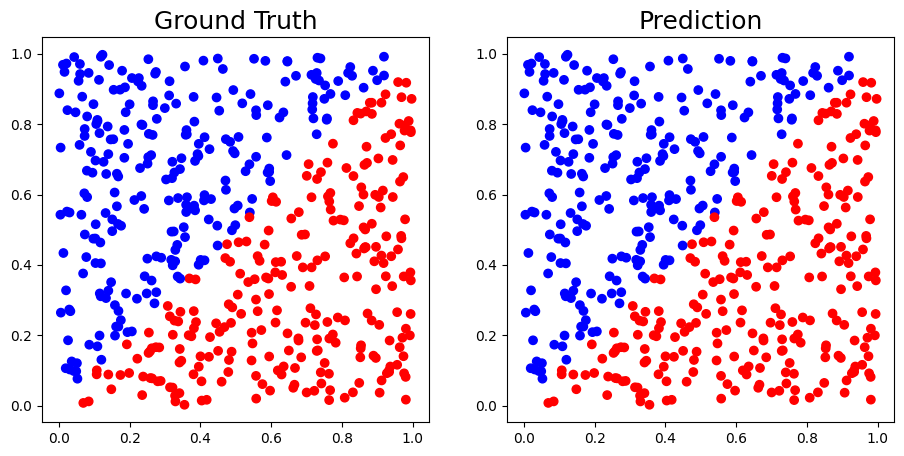

In [5]:
""" Customize your own code if needed """
net = SimpleNet(2000, momentum=0.95, is_kaiming=True, activate_function=LeakyReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 89.34%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 98.69%
Epochs 200 accuracy: 99.08%
Epochs 300 accuracy: 99.35%
Epochs 400 accuracy: 99.08%
Epochs 500 accuracy: 99.23%
Epochs 600 accuracy: 99.17%
Epochs 700 accuracy: 99.08%
Epochs 800 accuracy: 98.89%
Epochs 900 accuracy: 99.28%
Epochs 1000 accuracy: 99.52%
Epochs 1100 accuracy: 99.25%
Epochs 1200 accuracy: 99.72%
Epochs 1300 accuracy: 99.48%
Epochs 1400 accuracy: 99.22%
Epochs 1500 accuracy: 99.54%
Epochs 1600 accuracy: 99.79%
Epochs 1700 accuracy: 99.37%
Epochs 1800 accuracy: 99.96%
Epochs 1900 accuracy: 99.98%
Training finished
accuracy: 99.98%


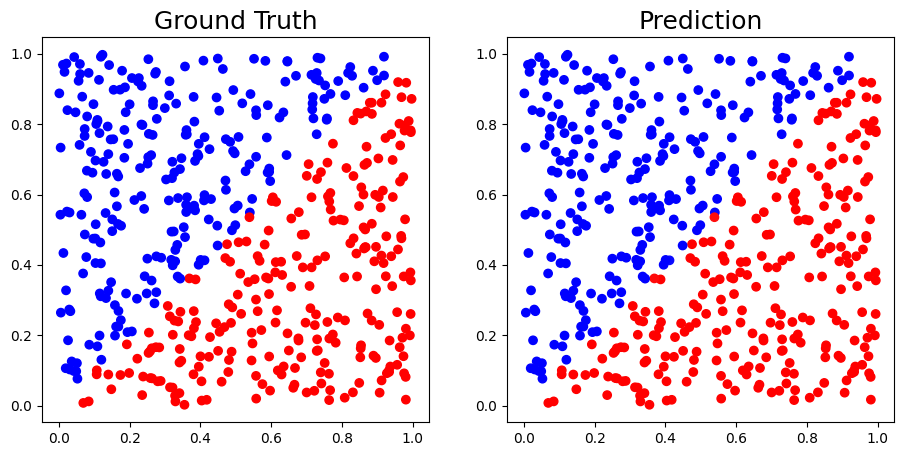

In [6]:
""" Customize your own code if needed """
net = SimpleNet(2000, momentum=0.95, is_kaiming=True, activate_function=SiLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

### Run "XOR"

Epochs 0 accuracy: 49.90%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 91.37%
Epochs 200 accuracy: 91.95%
Epochs 300 accuracy: 93.83%
Epochs 400 accuracy: 92.24%
Epochs 500 accuracy: 95.67%
Epochs 600 accuracy: 91.14%
Epochs 700 accuracy: 97.79%
Epochs 800 accuracy: 96.96%
Epochs 900 accuracy: 96.05%
Epochs 1000 accuracy: 96.73%
Epochs 1100 accuracy: 98.34%
Epochs 1200 accuracy: 98.52%
Epochs 1300 accuracy: 98.78%
Epochs 1400 accuracy: 94.98%
Epochs 1500 accuracy: 99.07%
Epochs 1600 accuracy: 99.03%
Epochs 1700 accuracy: 98.41%
Epochs 1800 accuracy: 98.39%
Epochs 1900 accuracy: 98.74%
Training finished
accuracy: 98.62%


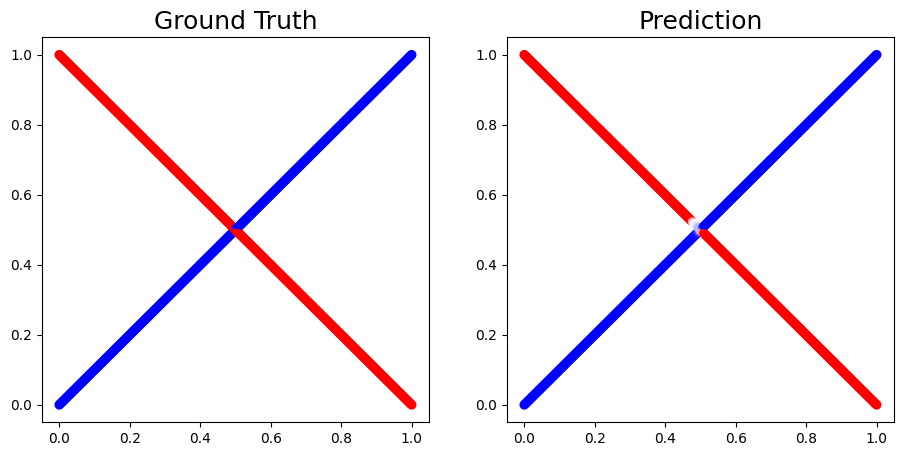

In [9]:
""" Customize your own code if needed """
data, label = GenData.fetch_data("XOR", 500)

net = SimpleNet(2000, is_kaiming=False, momentum=0.95)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 56.38%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 94.79%
Epochs 200 accuracy: 96.38%
Epochs 300 accuracy: 96.97%
Epochs 400 accuracy: 97.44%
Epochs 500 accuracy: 97.71%
Epochs 600 accuracy: 97.84%
Epochs 700 accuracy: 97.96%
Epochs 800 accuracy: 97.90%
Epochs 900 accuracy: 98.23%
Epochs 1000 accuracy: 98.13%
Epochs 1100 accuracy: 98.21%
Epochs 1200 accuracy: 98.34%
Epochs 1300 accuracy: 98.39%
Epochs 1400 accuracy: 98.46%
Epochs 1500 accuracy: 98.45%
Epochs 1600 accuracy: 98.58%
Epochs 1700 accuracy: 98.25%
Epochs 1800 accuracy: 98.37%
Epochs 1900 accuracy: 98.37%
Training finished
accuracy: 98.50%


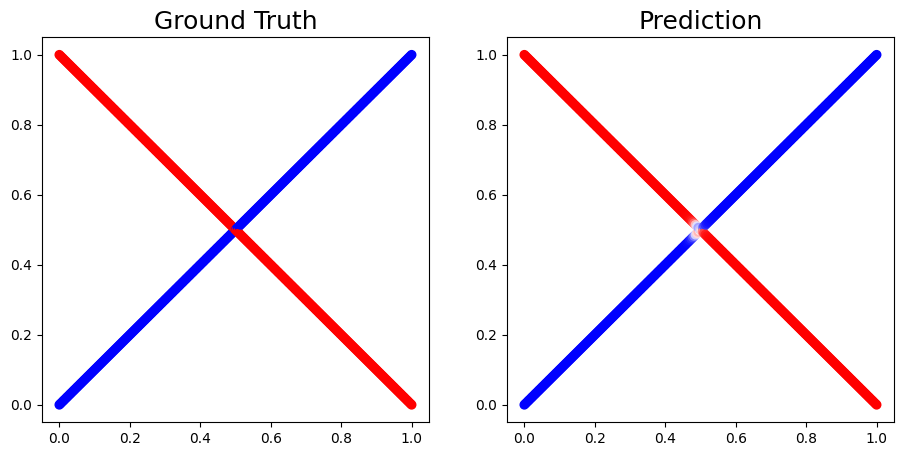

In [11]:
""" Customize your own code if needed """
net = SimpleNet(2000, is_kaiming=True, momentum=0, activate_function=ReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 62.93%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 94.97%
Epochs 200 accuracy: 96.42%
Epochs 300 accuracy: 97.03%
Epochs 400 accuracy: 97.36%
Epochs 500 accuracy: 97.56%
Epochs 600 accuracy: 97.78%
Epochs 700 accuracy: 97.97%
Epochs 800 accuracy: 98.15%
Epochs 900 accuracy: 98.17%
Epochs 1000 accuracy: 98.30%
Epochs 1100 accuracy: 98.32%
Epochs 1200 accuracy: 98.39%
Epochs 1300 accuracy: 98.47%
Epochs 1400 accuracy: 98.41%
Epochs 1500 accuracy: 98.54%
Epochs 1600 accuracy: 98.66%
Epochs 1700 accuracy: 98.69%
Epochs 1800 accuracy: 98.71%
Epochs 1900 accuracy: 98.76%
Training finished
accuracy: 98.79%


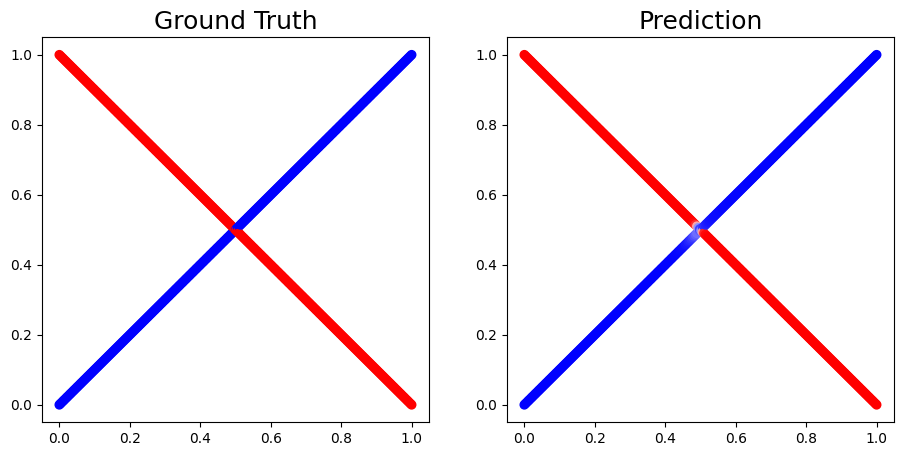

In [12]:
""" Customize your own code if needed """
net = SimpleNet(2000, is_kaiming=True, momentum=0, activate_function=LeakyReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 53.82%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 94.24%
Epochs 200 accuracy: 96.04%
Epochs 300 accuracy: 96.61%
Epochs 400 accuracy: 97.17%
Epochs 500 accuracy: 97.37%
Epochs 600 accuracy: 97.68%
Epochs 700 accuracy: 97.74%
Epochs 800 accuracy: 98.00%
Epochs 900 accuracy: 98.11%
Epochs 1000 accuracy: 98.24%
Epochs 1100 accuracy: 98.21%
Epochs 1200 accuracy: 98.38%
Epochs 1300 accuracy: 98.46%
Epochs 1400 accuracy: 98.47%
Epochs 1500 accuracy: 98.52%
Epochs 1600 accuracy: 98.58%
Epochs 1700 accuracy: 98.62%
Epochs 1800 accuracy: 98.56%
Epochs 1900 accuracy: 98.45%
Training finished
accuracy: 96.35%


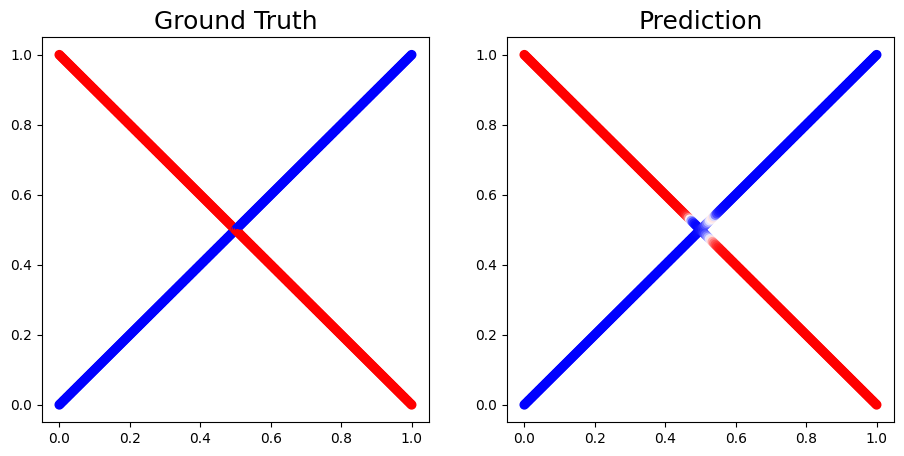

In [13]:
""" Customize your own code if needed """
net = SimpleNet(2000, is_kaiming=True, momentum=0, activate_function=LeakyReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

### Run "Chessboard"

Epochs 0 accuracy: 49.20%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 61.95%
Epochs 200 accuracy: 84.40%
Epochs 300 accuracy: 87.31%
Epochs 400 accuracy: 89.57%
Epochs 500 accuracy: 89.92%
Epochs 600 accuracy: 91.40%
Epochs 700 accuracy: 89.75%
Epochs 800 accuracy: 92.26%
Epochs 900 accuracy: 91.01%
Epochs 1000 accuracy: 92.90%
Epochs 1100 accuracy: 93.01%
Epochs 1200 accuracy: 93.19%
Epochs 1300 accuracy: 92.99%
Epochs 1400 accuracy: 93.15%
Epochs 1500 accuracy: 94.92%
Epochs 1600 accuracy: 91.11%
Epochs 1700 accuracy: 94.74%
Epochs 1800 accuracy: 94.17%
Epochs 1900 accuracy: 95.96%
Training finished
accuracy: 94.32%


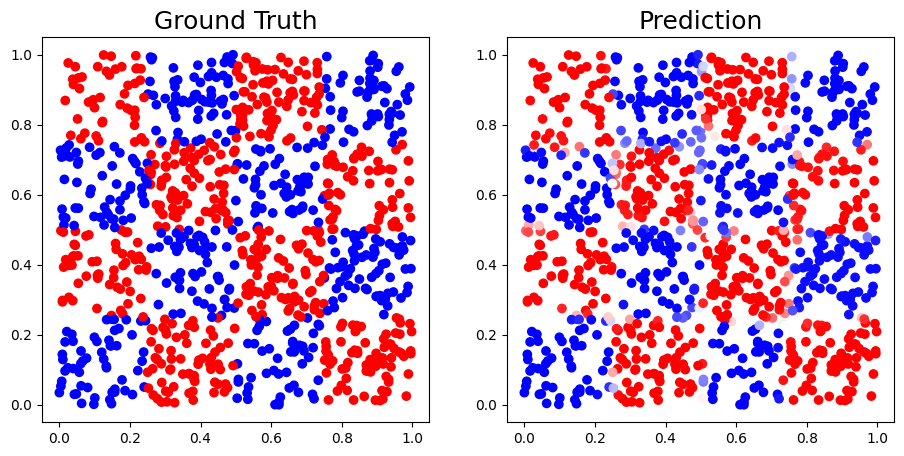

In [14]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)

net = SimpleNet(2000, is_kaiming=False, momentum=0.95)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 50.49%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 70.45%
Epochs 200 accuracy: 83.66%
Epochs 300 accuracy: 89.28%
Epochs 400 accuracy: 90.88%
Epochs 500 accuracy: 91.80%
Epochs 600 accuracy: 92.07%
Epochs 700 accuracy: 92.99%
Epochs 800 accuracy: 92.16%
Epochs 900 accuracy: 94.29%
Epochs 1000 accuracy: 95.18%
Epochs 1100 accuracy: 94.38%
Epochs 1200 accuracy: 94.53%
Epochs 1300 accuracy: 92.42%
Epochs 1400 accuracy: 96.58%
Epochs 1500 accuracy: 96.22%
Epochs 1600 accuracy: 95.23%
Epochs 1700 accuracy: 95.38%
Epochs 1800 accuracy: 94.57%
Epochs 1900 accuracy: 96.32%
Training finished
accuracy: 96.67%


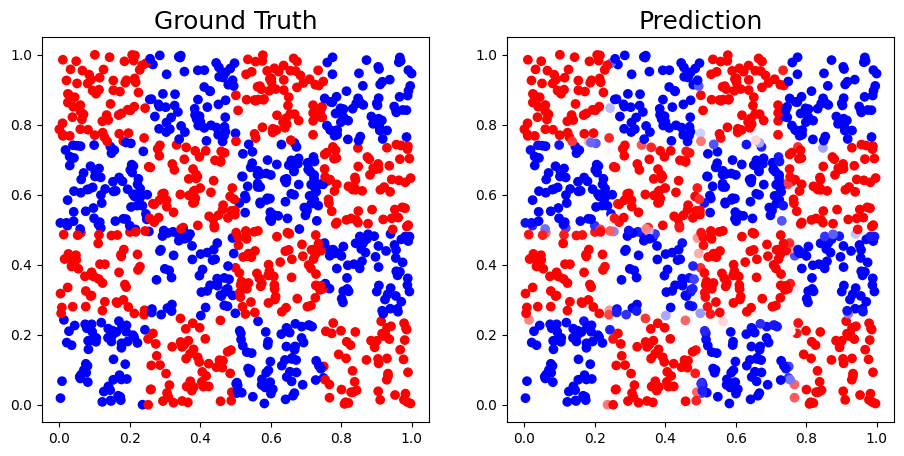

In [15]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)

net = SimpleNet(2000, is_kaiming=True, momentum=0, activate_function=ReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 50.65%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 69.99%
Epochs 200 accuracy: 84.93%
Epochs 300 accuracy: 88.76%
Epochs 400 accuracy: 89.14%
Epochs 500 accuracy: 92.04%
Epochs 600 accuracy: 91.63%
Epochs 700 accuracy: 93.59%
Epochs 800 accuracy: 91.41%
Epochs 900 accuracy: 93.91%
Epochs 1000 accuracy: 95.07%
Epochs 1100 accuracy: 92.28%
Epochs 1200 accuracy: 92.93%
Epochs 1300 accuracy: 93.58%
Epochs 1400 accuracy: 94.89%
Epochs 1500 accuracy: 92.94%
Epochs 1600 accuracy: 95.11%
Epochs 1700 accuracy: 94.62%
Epochs 1800 accuracy: 93.52%
Epochs 1900 accuracy: 94.91%
Training finished
accuracy: 95.70%


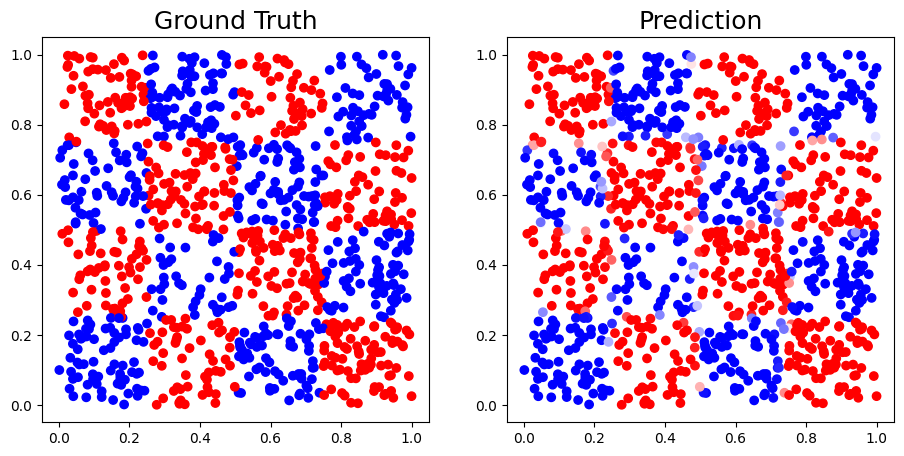

In [16]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)

net = SimpleNet(2000, is_kaiming=True, momentum=0, activate_function=LeakyReLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

Epochs 0 accuracy: 50.06%


/tmp/ipykernel_2468115/26345794.py:353: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("accuracy: %.2f" % ((1 - error) * 100) + "%")


Epochs 100 accuracy: 50.14%
Epochs 200 accuracy: 50.43%
Epochs 300 accuracy: 50.89%
Epochs 400 accuracy: 50.90%
Epochs 500 accuracy: 50.92%
Epochs 600 accuracy: 50.95%
Epochs 700 accuracy: 50.99%
Epochs 800 accuracy: 51.05%
Epochs 900 accuracy: 51.24%
Epochs 1000 accuracy: 51.83%
Epochs 1100 accuracy: 53.64%
Epochs 1200 accuracy: 59.34%
Epochs 1300 accuracy: 51.50%
Epochs 1400 accuracy: 51.50%
Epochs 1500 accuracy: 51.50%
Epochs 1600 accuracy: 51.50%
Epochs 1700 accuracy: 51.50%
Epochs 1800 accuracy: 51.50%
Epochs 1900 accuracy: 51.50%
Training finished
accuracy: 51.50%


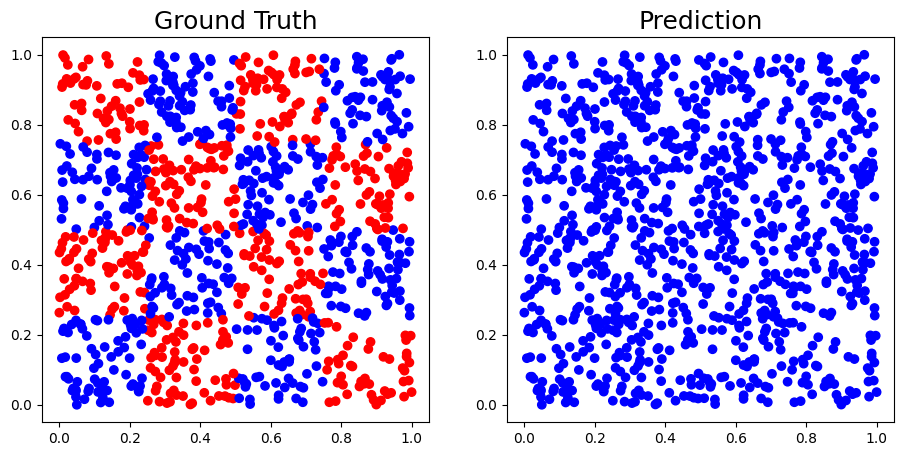

In [17]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)

net = SimpleNet(2000, is_kaiming=True, momentum=0, activate_function=SiLU)
net.train(data, label)

pred_result = net.forward(data)
SimpleNet.plot_result(data, label, pred_result)

## Params Search

In [18]:
import itertools

param_grid = {
    'num_step': [2000],
    'momentum': [None, 0.9, 0.95, 0.8],
    'weight_decay': [None, 0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'is_kaiming': [True, False],
    'activate_function': [Sigmoid, ReLU, LeakyReLU, SiLU]
}

param_combinations = list(itertools.product(*param_grid.values()))

record = {}

set_seed(42)
data, label = GenData.fetch_data("Chessboard", 500)
for i, params in enumerate(param_combinations):
    set_seed(42)
    net = SimpleNet(**dict(zip(param_grid.keys(), params)))
    net.train(data, label)
    acc = net.test(data, label)

    record.update({i: {'params': params, 'accuracy': acc}})

for acc in sorted(record, key=lambda x: record[x]['accuracy'], reverse=True):
    print(f"Accuracy: {record[acc]['accuracy']:}%, Params: {record[acc]['params']}")

TypeError: SimpleNet.__init__() got an unexpected keyword argument 'weight_decay'